In [7]:
# K Nearest Neighbors (KNN) with Dynamic Time Warping (DTW)

import numpy as np
import pandas as pd
from scipy.spatial import distance
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# https://stackoverflow.com/questions/57015499/how-to-use-dynamic-time-warping-with-knn-in-python

# custom metric
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]



In [8]:

df_feature=pd.read_csv('../data/df_feature.csv')
X=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
y=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)

selected_features=list(df_feature[df_feature.select==1]['variable'])
X_train=X[selected_features][:-96]
y_train=y['y_oecd'][:-96]
X_test=X[selected_features][-96:]
y_test=y['y_oecd'][-96:]

In [9]:
#train
parameters = {'n_neighbors':[2, 3]}

## cv: cv=TimeSeriesSplit(n_splits=3), cv=KFold(n_splits=3, shuffle=False, random_state=14)

clf = GridSearchCV(KNeighborsClassifier(metric=DTW), parameters, cv=TimeSeriesSplit(n_splits=3), 
                   verbose=3, n_jobs=-1)
clf.fit(X_train, y_train)



Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END .....................n_neighbors=3;, score=0.545 total time=  17.5s
[CV 1/3] END .....................n_neighbors=2;, score=0.537 total time=  17.6s
[CV 2/3] END .....................n_neighbors=2;, score=0.675 total time=  30.3s
[CV 2/3] END .....................n_neighbors=3;, score=0.618 total time=  29.5s
[CV 3/3] END .....................n_neighbors=3;, score=0.650 total time=  41.7s
[CV 3/3] END .....................n_neighbors=2;, score=0.724 total time=  42.9s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=KNeighborsClassifier(metric=<function DTW at 0x1688e6200>),
             n_jobs=-1, param_grid={'n_neighbors': [2, 3]}, verbose=3)

In [10]:
dir(clf)
#clf.cv_results_

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 '_validate_params',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'feature_names_in_',
 'fit',
 'get_params',
 'inverse_transform',
 

In [11]:
y_pred_prob=clf.predict_proba(X_test)

0     0.0
1     0.5
2     0.5
3     0.5
4     0.5
     ... 
91    0.0
92    1.0
93    1.0
94    0.5
95    1.0
Name: 1, Length: 96, dtype: float64

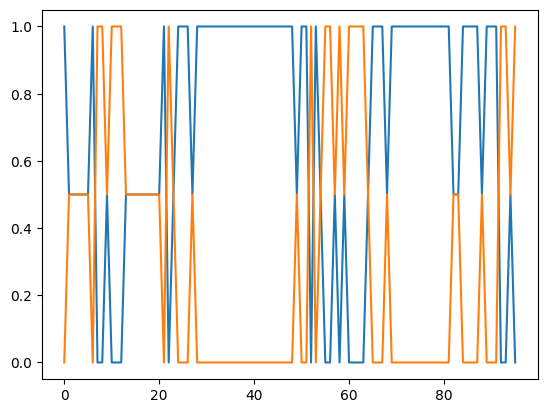

In [12]:
import matplotlib.pyplot as plt

fig, ax=plt.subplots()
#ax.plot(y_pred_prob[:,1])
ax.plot(y_pred_prob)
pd.DataFrame(y_pred_prob)[1]
#pd.DataFrame(y['GDP_N'][-96:]).reset_index()

In [13]:
#evaluate
X_test=X[selected_features][-96:]
y_test=y['y_oecd'][-96:]

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.88      0.82        68
         1.0       0.53      0.32      0.40        28

    accuracy                           0.72        96
   macro avg       0.64      0.60      0.61        96
weighted avg       0.69      0.72      0.69        96



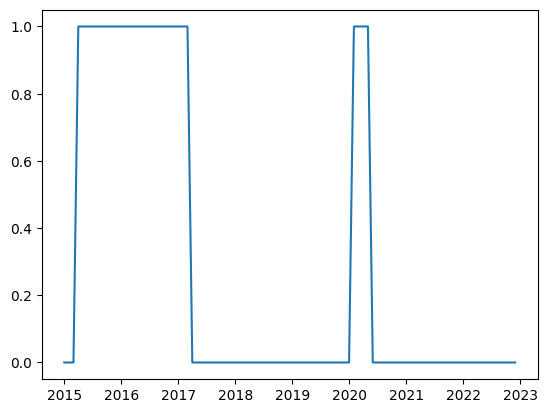

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt



y_test=y['y_oecd'][-96:]
plt.plot(y_test)

In [15]:
import pickle

with open ('../result/clf_1.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [16]:


y['y_agg'].groupby(y['y_oecd']).count()

y_oecd
0.0    349
1.0    239
Name: y_agg, dtype: int64

In [17]:
## test split = 36 month
## train, validation with the rest(47 years)

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
kfold = KFold(n_splits=3, shuffle=False)

X_tv=X[selected_features][:-36]
X_test=X[selected_features][-36:]
y_tv=y['y_oecd'][:-36]
y_test=y['y_oecd'][-36:]

for train_idx, val_idx in kfold.split(X_test):
    X_train, X_val=X_tv[train_idx], X_tv[val_idx]
    y_train, y_val=y_tv[train_idx], y_tv[val_idx]
    

                                    

KeyError: "None of [Index([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,\n       30, 31, 32, 33, 34, 35],\n      dtype='int64')] are in the [columns]"

In [ ]:
KFold.split()